<a href="https://colab.research.google.com/github/dimaswisodewo/Time-Series-Forecasting-with-ARIMA-and-SARIMA/blob/master/Time_Series_Forecasting_with_ARIMA_and_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Function**

In [0]:
def MakeDataFrame(data, list_of_column):
    df = pd.DataFrame(data, columns = list_of_column) 
    return df

def ConcatDataFrame(data1, data2):
    data_full = pd.concat([data1, data2], axis=1, sort=False)
    return data_full

def CheckRollingMean(dataset, input_window=12):
    rolMean = dataset.rolling(window=input_window).mean() # window = 12 karena data bulanan
    rolStd = dataset.rolling(window=input_window).std()
    print('Rolling Mean: ', rolMean)
    print('Rolling STD: ', rolStd)

from statsmodels.tsa.stattools import adfuller
def TestStationarity(dataset):
    
    # Determining rolling statistics
    movingAverage = dataset.rolling(window=12).mean()
    movingSTD = dataset.rolling(window=12).std()
        
    # Plot rolling statistics
    orig = plt.plot(dataset, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey-Fuller Test
    print('Result of Dickey-Fuller Test')
    dftest = adfuller(dataset['Price'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p=value', 'Lags Used', 'Number of Observation Used'])
    for key,value in dftest[4].items():
        dfoutput['critical value (%s)'%key] = value
    print(dfoutput)

from statsmodels.tsa.seasonal import seasonal_decompose
def SeasonalDecompose(dataset, input_freq=None):
    decomposed = seasonal_decompose(dataset, freq=input_freq)

    trend = decomposed.trend
    seasonal = decomposed.seasonal
    residual = decomposed.resid

    plt.subplot(411)
    plt.plot(dataset, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residual')
    plt.legend(loc='best')
    plt.tight_layout()
    return decomposed
    
from statsmodels.tsa.stattools import acf, pacf
def Plot_ACF_PACF(dataset):
    # ACF and PACF plot
    ACF = acf(dataset, nlags=20)
    PACF = pacf(dataset, nlags=20, method='ols')

    # plot ACF
    plt.subplot(121)
    plt.plot(ACF)
    plt.axhline(y=0, linestyle='--', color='grey')
    plt.axhline(y=-1.96/np.sqrt(len(dataset)), linestyle='--', color='gray')
    plt.axhline(y=1.96/np.sqrt(len(dataset)), linestyle='--', color='gray')
    plt.title("AutoCorrelation Function")

    # plot PACF
    plt.subplot(122)
    plt.plot(PACF)
    plt.axhline(y=0, linestyle='--', color='grey')
    plt.axhline(y=-1.96/np.sqrt(len(dataset)), linestyle='--', color='gray')
    plt.axhline(y=1.96/np.sqrt(len(dataset)), linestyle='--', color='gray')
    plt.title("Partial AutoCorrelation Function")

    plt.tight_layout()

def train_test_builder(dataset, size_test=0.3):
    test_count = int(len(dataset)*size_test)
    train_count = len(dataset)-test_count
    
    train = dataset[:train_count]
    test = dataset[train_count:]
    
    return train, test

from statsmodels.tsa.arima_model import ARIMA
def StepForwardARIMA(input_order, data_train, data_test):
    history = data_train
    predictions = list()
    
    for t in range(len(data_test)):
        model = ARIMA(history, order=input_order)
        model_fit = model.fit()
        pred = model_fit.forecast()
        pred = pred[0]
        obs = data_test[t:t+1]
        history = pd.concat([history, obs])
        predictions.append(pred)
    
    predictions_df = MakeDataFrame(predictions, ['Price'])
    index = data_test.index
    indexed_predictions = predictions_df.set_index(index)
    
    return indexed_predictions
    
def PlotPredictARIMA(input_order, data_train):
    start = input_order[1]
    end = len(data_train)
    model = ARIMA(data_train, order=input_order)
    model_fit = model.fit()
    model_fit.plot_predict(start=start, end=end)

def ComparePredictions(predictions, data_test):
    print('-------------------- Compare Predictions --------------------')
    for t in range(len(data_test)):
        pred = predictions.iloc[t][0]
        obs = data_test.iloc[t][0]
        print('predicted: ', pred, ', expected: ', obs, ', error: ', abs(pred-obs))
    print('-------------------------------------------------------------')
        
        
def MAPE(predictions, data_test):
    temp = list()
    
    for t in range(len(predictions)):
        var = abs((data_test.iloc[t][0]-predictions.iloc[t][0])/data_test.iloc[t][0])
        temp.append(var)

    mape = 100*(1/len(predictions)*sum(temp))
    
    return mape

def EvaluateParametersARIMA(data_train, data_test, p_values, d_values, q_values):
    data_test_log = np.log(data_test)
    best_score, best_cfg = float("inf"), 0
    count = 0
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                count += 1
                try:
                    predictions = StepForwardARIMA(order, data_train, data_test_log)
                    predictions_original_value = np.exp(predictions)
                    mse = mean_squared_error(data_test, predictions_original_value)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('(', count, ')', ' ARIMA', order, 'MSE=', mse)
                except:
                    print('(', count, ')')
                    continue
                    
    print('Best ARIMA', best_cfg, 'MSE=', best_score)

from statsmodels.tsa.statespace.sarimax import SARIMAX
def StepForwardSARIMA(input_order, data_train, data_test):
    order, sorder, trend = input_order
    history = data_train
    predictions = list()
    
    for t in range(len(data_test)):
        model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend,
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit()
        pred = model_fit.forecast()
        pred = pred.values[0]
        obs = data_test[t:t+1]
        history = pd.concat([history, obs])
        predictions.append(pred)
        
    predictions_df = MakeDataFrame(predictions, ['Price'])
    index = data_test.index
    indexed_predictions = predictions_df.set_index(index)
    
    return indexed_predictions

# belum direfactor
def EvaluateParametersSARIMA(data_train, data_test):
    p_values = [0, 1, 2]
    q_values = [0, 1]
    d_values = [0, 1, 2]
    t_values = ['n', 'c', 't', 'ct']
    P_values = [0, 1, 2]
    D_values = [0, 1]
    Q_values = [0, 1, 2]
    m_values = [0, 4, 12]
    
    count = 0
    data_test_log = np.log(data_test)
    best_score, best_cfg = float("inf"), 0
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for t in t_values:
                    for P in P_values:
                        for D in D_values:
                            for Q in Q_values:
                                for m in m_values:
                                    order = [(p,d,q), (P,D,Q,m), t]
                                    count += 1
                                    try:
                                        predictions = StepForwardSARIMA(order, data_train, data_test_log)
                                        predictions_original_value = np.exp(predictions)
                                        mse = mean_squared_error(data_test, predictions_original_value)
                                        if mse < best_score:
                                            best_score, best_cfg = mse, order
                                        print('(', count, ') SARIMA', order, 'MSE=', mse)
                                    except:
                                        print('(', count, ')')
                                        continue
    print('Best SARIMA', best_cfg, 'MSE=', best_score)
    
def RSS(fitted_values, train_data):
    train_diff = train_data.diff()
    train_diff.dropna(inplace=True)
    print('sum of squares of residuals (RSS) : %f' %sum((fitted_values - train_diff['Price'])**2))
    
def EvaluateKNNRegressor(n_values, p_values, weight_values, X_train, y_train, X_test, y_test):
    n_best = -1
    p_best = -1
    weight_best = '-'
    mse_best = float('inf')
    
    for n in n_values:
        for p in p_values:
            for weight in weight_values:
                try:
                    KNN = KNeighborsRegressor(n_neighbors=n)
                    KNN.fit(X_train, y_train)
                    pred = KNN.predict(X_test)
                    mse = mean_squared_error(y_test, pred)
                    if mse < mse_best:
                        mse_best = mse
                        n_best = n
                        p_best = p
                        weight_best = weight
                    print('n:', n, 'p:', p, 'weight:', weight, 'mse:', mse)
                except:
                    print('n:', n, 'p:', p, 'weight:', weight)
                    continue
        
    print('Best --> n:', n_best,'p:', p_best, 'weight:', weight_best, 'mse:', mse_best)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Import + Preprocessing**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams

plt.style.use('fivethirtyeight') 
rcParams['figure.figsize'] = 10,6

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [0]:
from google.colab import files
uploaded = files.upload()

Saving wfp_food_prices_indonesia (2).csv to wfp_food_prices_indonesia (2).csv


In [0]:
uploaded

{'wfp_food_prices_indonesia (2).csv': b'date,cmname,unit,category,price,currency,country,admname,adm1id,mktname,mktid,cmid,ptid,umid,catid,sn,default\n#date,#item+name,#item+unit,#item+type,#value,#currency,#country+name,#adm1+name,#adm1+code,#name+market,,#item+code,,,#item+type+code,#meta+id,\n2007-01-15,Rice - Retail,KG,cereals and tubers,5941.9752,IDR,Indonesia,,0,National Average,974,52,15,5,1,974_52_15_5,\n2007-02-15,Rice - Retail,KG,cereals and tubers,6445.0,IDR,Indonesia,,0,National Average,974,52,15,5,1,974_52_15_5,\n2007-03-15,Rice - Retail,KG,cereals and tubers,6414.0,IDR,Indonesia,,0,National Average,974,52,15,5,1,974_52_15_5,\n2007-04-15,Rice - Retail,KG,cereals and tubers,6083.0,IDR,Indonesia,,0,National Average,974,52,15,5,1,974_52_15_5,\n2007-05-15,Rice - Retail,KG,cereals and tubers,5955.0,IDR,Indonesia,,0,National Average,974,52,15,5,1,974_52_15_5,\n2007-06-15,Rice - Retail,KG,cereals and tubers,5949.0,IDR,Indonesia,,0,National Average,974,52,15,5,1,974_52_15_5,\n2007

In [0]:
import io

colNames = ['date', 'cmname', 'price']
dataset_wfp = pd.read_csv(io.StringIO(uploaded['wfp_food_prices_indonesia (2).csv'].decode('utf-8')), usecols=colNames)

dataset_wfp.head()

,date,cmname,price
0,#date,#item+name,#value
1,2007-01-15,Rice - Retail,5941.9752
2,2007-02-15,Rice - Retail,6445.0
3,2007-03-15,Rice - Retail,6414.0
4,2007-04-15,Rice - Retail,6083.0


In [0]:
unique = []
for i in dataset_wfp.cmname:
    if i not in unique:
        unique.append(i)
        
unique

['#item+name',
 'Rice - Retail',
 'Wheat flour - Retail',
 'Meat (chicken, broiler) - Retail',
 'Chili (red) - Retail',
 'Eggs - Retail',
 'Milk (condensed) - Retail',
 'Oil (vegetable) - Retail',
 'Sugar - Retail',
 'Meat (beef) - Retail',
 'Fuel (kerosene) - Retail',
 'Chili (birdâ€™s eye)   - Retail']

In [0]:
chicken_count = 0
egg_count = 0
chicken = []
egg = []
chicken_date = []
egg_date = []

for i in range(1, len(dataset_wfp)):
    if dataset_wfp.iloc[i][1] == "Meat (chicken, broiler) - Retail":
        chicken.append(dataset_wfp.iloc[i][2])
        chicken_date.append(dataset_wfp.iloc[i][0])
        chicken_count += 1
    elif dataset_wfp.iloc[i][1] == "Eggs - Retail":
        egg.append(dataset_wfp.iloc[i][2])
        egg_date.append(dataset_wfp.iloc[i][0])
        egg_count += 1
        if dataset_wfp.iloc[i][0] == "2013-03-15": #instance yang null ditambahkan manual
            egg.append(None)
            egg_date.append("2013-04-15")
            egg_count += 1
        
print('chicken count: ', chicken_count)
print('egg count: ', egg_count)

chicken count:  147
egg count:  147


In [0]:
print(np.setdiff1d(chicken_date, egg_date))

[]


In [0]:
X_chicken = MakeDataFrame(chicken, ["Price"])
X_chicken_date = MakeDataFrame(chicken_date, ["Date"])
X_egg = MakeDataFrame(egg, ["Price"])
X_egg_date = MakeDataFrame(egg_date, ["Date"])

X_chicken_full = ConcatDataFrame(X_chicken_date, X_chicken)
X_egg_full = ConcatDataFrame(X_egg_date, X_egg)

X_chicken_full['Date'] = pd.to_datetime(X_chicken_full['Date'], infer_datetime_format=True)
X_chicken_full = X_chicken_full.set_index(['Date'])
X_egg_full['Date'] = pd.to_datetime(X_egg_full['Date'], infer_datetime_format=True)
X_egg_full = X_egg_full.set_index(['Date'])

In [0]:
X_chicken_full

,Price
Date,
2007-01-15,20122.7989
2007-02-15,18760.0
2007-03-15,20323.0
2007-04-15,22796.0
2007-05-15,22659.0
...,...
2018-12-15,44674.0
2019-01-15,45420.0
2019-02-15,43376.0


In [0]:
X_egg_full.tail(75)

,Price
Date,
2013-01-15,17558.0
2013-02-15,18018.0
2013-03-15,16310.0
2013-04-15,None
2013-05-15,16460.0
...,...
2018-12-15,24120.0
2019-01-15,24422.0
2019-02-15,23015.0


In [0]:
X_egg_full = X_egg_full.fillna(method='ffill')

In [0]:
X_egg_full.tail(75)

,Price
Date,
2013-01-15,17558.0
2013-02-15,18018.0
2013-03-15,16310.0
2013-04-15,16310.0
2013-05-15,16460.0
...,...
2018-12-15,24120.0
2019-01-15,24422.0
2019-02-15,23015.0


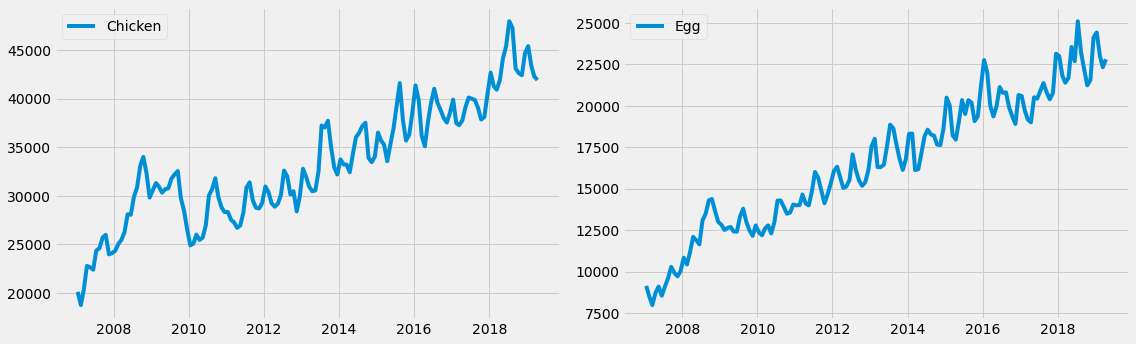

In [0]:
# Convert column Price type to float biar bisa di-plot
X_chicken_full['Price'] = X_chicken_full['Price'].astype(float)
X_egg_full['Price'] = X_egg_full['Price'].astype(float)

plt.figure(figsize=[16,5])
plt.subplot(121)
plt.plot(X_chicken_full, label='Chicken')
plt.legend(loc='best')
plt.subplot(122)
plt.plot(X_egg_full, label='Egg')
plt.legend(loc='best')
plt.tight_layout()

In [0]:
chicken_train, chicken_test = train_test_builder(X_chicken_full, size_test=0.2)
print('chicken train: ', len(chicken_train),',', 'chicken test: ', len(chicken_test))

egg_train, egg_test = train_test_builder(X_egg_full, size_test=0.2)
print('egg train: ', len(egg_train),',', 'egg test: ', len(egg_test))

chicken train:  118 , chicken test:  29
egg train:  118 , egg test:  29


In [0]:
chicken_train

,Price
Date,
2007-01-15,20122.7989
2007-02-15,18760.0000
2007-03-15,20323.0000
2007-04-15,22796.0000
2007-05-15,22659.0000
...,...
2016-06-15,39635.0000
2016-07-15,41034.0000
2016-08-15,39606.0000


In [0]:
egg_train

,Price
Date,
2007-01-15,9150.7401
2007-02-15,8486.4410
2007-03-15,7993.5490
2007-04-15,8732.9076
2007-05-15,9106.7251
...,...
2016-06-15,21135.0000
2016-07-15,20786.0000
2016-08-15,20815.0000


**Dataset Harga Daging Ayam**

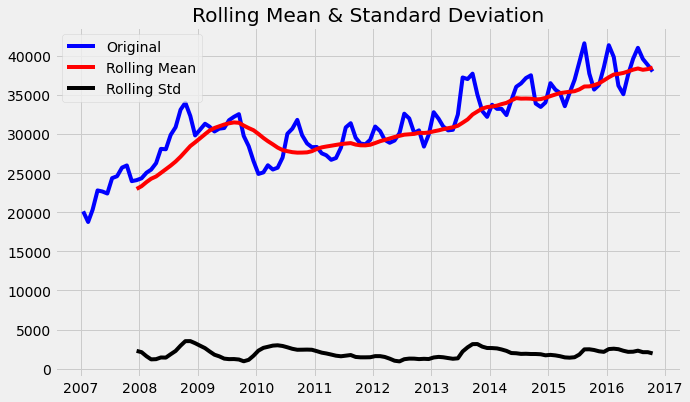

Result of Dickey-Fuller Test
Test Statistic                 -0.897860
p=value                         0.788676
Lags Used                      12.000000
Number of Observation Used    105.000000
critical value (1%)            -3.494220
critical value (5%)            -2.889485
critical value (10%)           -2.581676
dtype: float64


In [0]:
TestStationarity(chicken_train)

In [0]:
# Log Transformation
chicken_logScale = np.log(chicken_train)

chicken_logScale

,Price
Date,
2007-01-15,9.909609
2007-02-15,9.839482
2007-03-15,9.919509
2007-04-15,10.034340
2007-05-15,10.028312
...,...
2016-06-15,10.587468
2016-07-15,10.622156
2016-08-15,10.586736


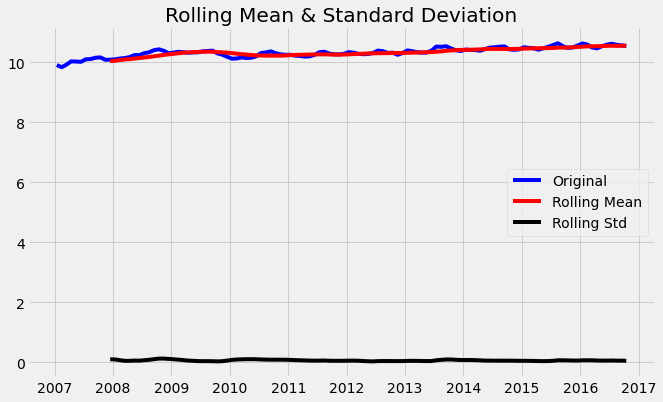

Result of Dickey-Fuller Test
Test Statistic                 -1.220064
p=value                         0.664905
Lags Used                      12.000000
Number of Observation Used    105.000000
critical value (1%)            -3.494220
critical value (5%)            -2.889485
critical value (10%)           -2.581676
dtype: float64


In [0]:
TestStationarity(chicken_logScale)

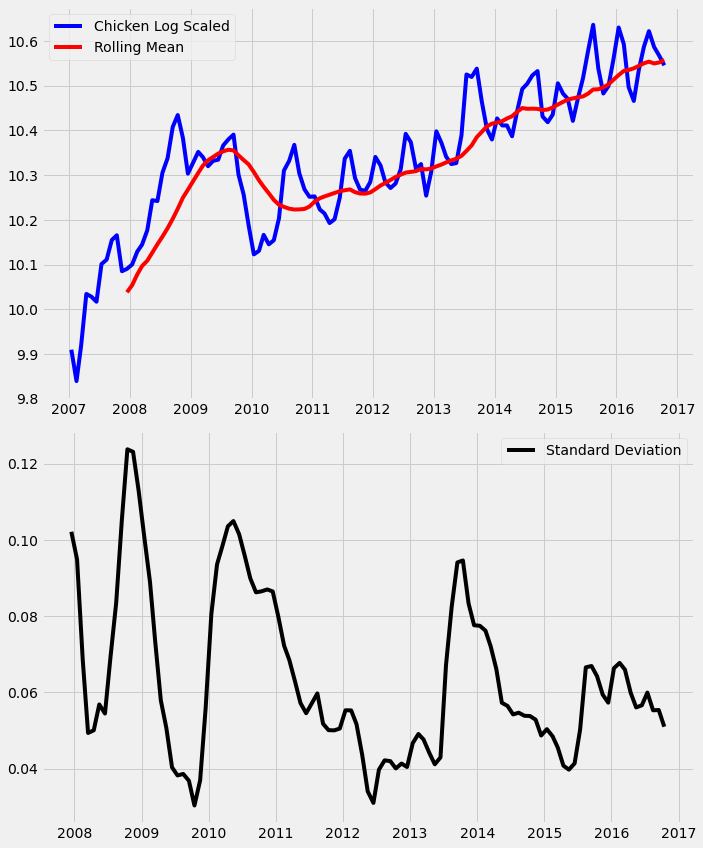

In [0]:
# Test Stationary
movingAverage_chicken = chicken_logScale.rolling(window=12).mean()
movingStd_chicken = chicken_logScale.rolling(window=12).std()

# Plot
plt.figure(figsize=[10,12])
plt.subplot(211)
plt.plot(chicken_logScale, label='Chicken Log Scaled', color='blue')
plt.plot(movingAverage_chicken, label='Rolling Mean', color='red')
plt.legend(loc='best')
plt.subplot(212)
#plt.plot(chicken_logScale, label='Chicken Log Scaled', color='blue')
plt.plot(movingStd_chicken, label='Standard Deviation', color='black')
plt.legend(loc='best')
plt.tight_layout()

In [0]:
# Differencing
chicken_log_diff = chicken_logScale.diff()

In [0]:
chicken_log_diff

,Price
Date,
2007-01-15,NaN
2007-02-15,-0.070127
2007-03-15,0.080026
2007-04-15,0.114832
2007-05-15,-0.006028
...,...
2016-06-15,0.052203
2016-07-15,0.034688
2016-08-15,-0.035420


In [0]:
chicken_log_diff.dropna(inplace=True)
chicken_log_diff

,Price
Date,
2007-02-15,-0.070127
2007-03-15,0.080026
2007-04-15,0.114832
2007-05-15,-0.006028
2007-06-15,-0.011362
...,...
2016-06-15,0.052203
2016-07-15,0.034688
2016-08-15,-0.035420


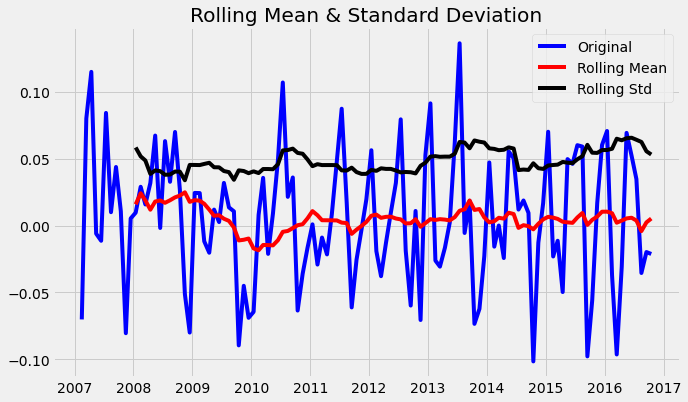

Result of Dickey-Fuller Test
Test Statistic                 -2.693662
p=value                         0.075141
Lags Used                      11.000000
Number of Observation Used    105.000000
critical value (1%)            -3.494220
critical value (5%)            -2.889485
critical value (10%)           -2.581676
dtype: float64


In [0]:
TestStationarity(chicken_log_diff)

In [0]:
chicken_log_diff_2 = chicken_log_diff.diff()
chicken_log_diff_2.dropna(inplace=True)

In [0]:
chicken_log_diff_2

,Price
Date,
2007-03-15,0.150153
2007-04-15,0.034806
2007-05-15,-0.120860
2007-06-15,-0.005334
2007-07-15,0.095520
...,...
2016-06-15,-0.017048
2016-07-15,-0.017515
2016-08-15,-0.070109


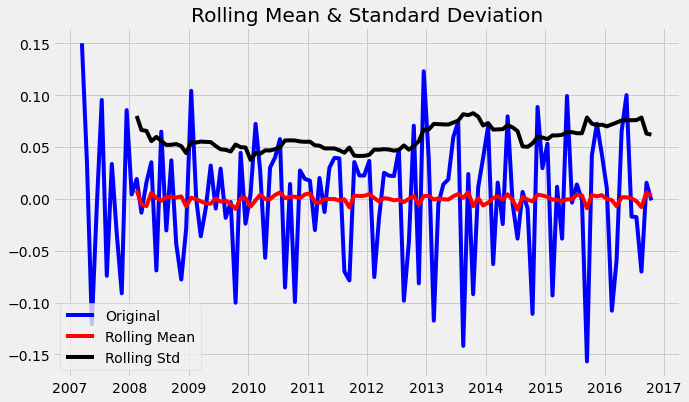

Result of Dickey-Fuller Test
Test Statistic                 -4.185817
p=value                         0.000696
Lags Used                      13.000000
Number of Observation Used    102.000000
critical value (1%)            -3.496149
critical value (5%)            -2.890321
critical value (10%)           -2.582122
dtype: float64


In [0]:
TestStationarity(chicken_log_diff_2)

**Dataset Harga Telur Ayam**

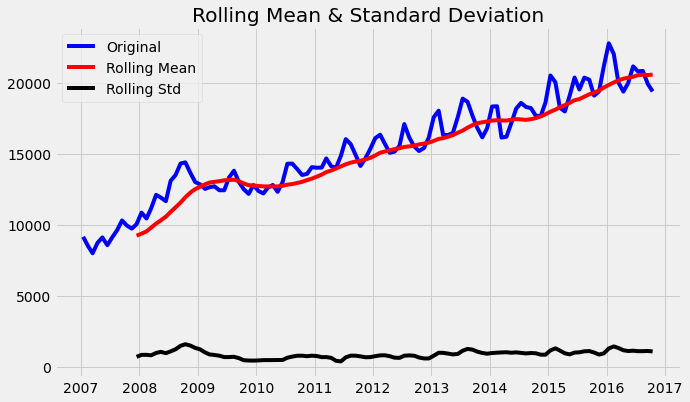

Result of Dickey-Fuller Test
Test Statistic                 -1.024929
p=value                         0.744064
Lags Used                      12.000000
Number of Observation Used    105.000000
critical value (1%)            -3.494220
critical value (5%)            -2.889485
critical value (10%)           -2.581676
dtype: float64


In [0]:
TestStationarity(egg_train)

In [0]:
egg_log = np.log(egg_train)
egg_log

,Price
Date,
2007-01-15,9.121590
2007-02-15,9.046225
2007-03-15,8.986390
2007-04-15,9.074854
2007-05-15,9.116768
...,...
2016-06-15,9.958686
2016-07-15,9.942035
2016-08-15,9.943429


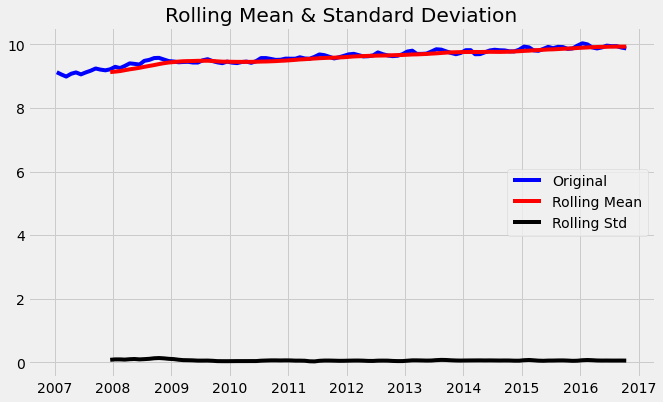

Result of Dickey-Fuller Test
Test Statistic                 -1.570313
p=value                         0.498487
Lags Used                      12.000000
Number of Observation Used    105.000000
critical value (1%)            -3.494220
critical value (5%)            -2.889485
critical value (10%)           -2.581676
dtype: float64


In [0]:
TestStationarity(egg_log)

In [0]:
egg_diff = egg_log.diff()
egg_diff.dropna(inplace=True)

egg_diff

,Price
Date,
2007-02-15,-0.075365
2007-03-15,-0.059835
2007-04-15,0.088464
2007-05-15,0.041915
2007-06-15,-0.062030
...,...
2016-06-15,0.056950
2016-07-15,-0.016651
2016-08-15,0.001394


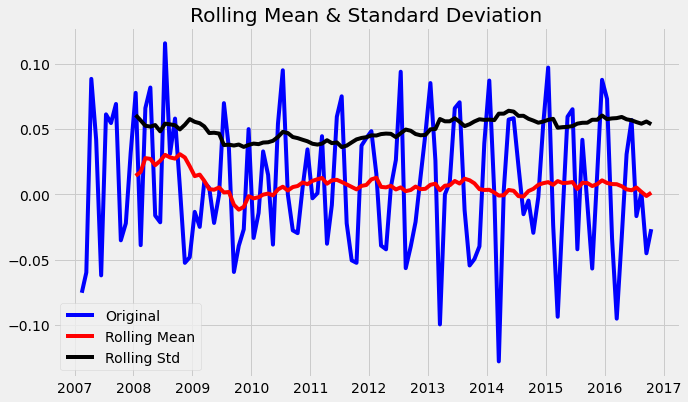

Result of Dickey-Fuller Test
Test Statistic                 -2.164888
p=value                         0.219235
Lags Used                      11.000000
Number of Observation Used    105.000000
critical value (1%)            -3.494220
critical value (5%)            -2.889485
critical value (10%)           -2.581676
dtype: float64


In [0]:
TestStationarity(egg_diff)

In [0]:
egg_diff2 = egg_diff.diff()
egg_diff2.dropna(inplace=True)

egg_diff2

,Price
Date,
2007-03-15,0.015530
2007-04-15,0.148298
2007-05-15,-0.046549
2007-06-15,-0.103945
2007-07-15,0.123321
...,...
2016-06-15,0.026230
2016-07-15,-0.073600
2016-08-15,0.018045


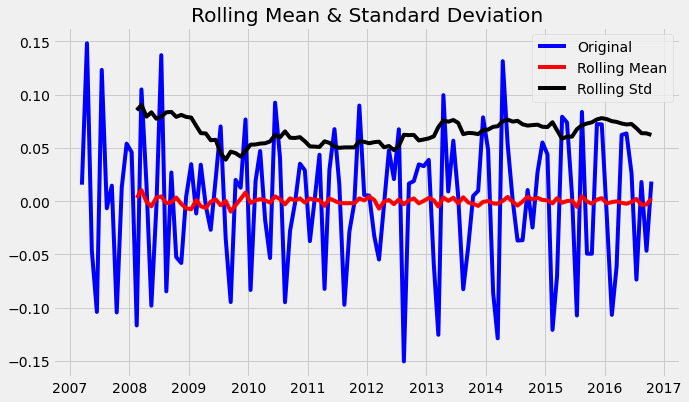

Result of Dickey-Fuller Test
Test Statistic               -8.317358e+00
p=value                       3.650234e-13
Lags Used                     1.000000e+01
Number of Observation Used    1.050000e+02
critical value (1%)          -3.494220e+00
critical value (5%)          -2.889485e+00
critical value (10%)         -2.581676e+00
dtype: float64


In [0]:
TestStationarity(egg_diff2)

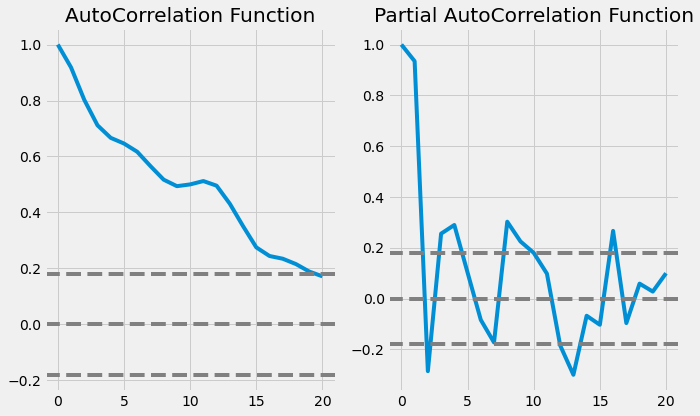

In [0]:
Plot_ACF_PACF(chicken_train)

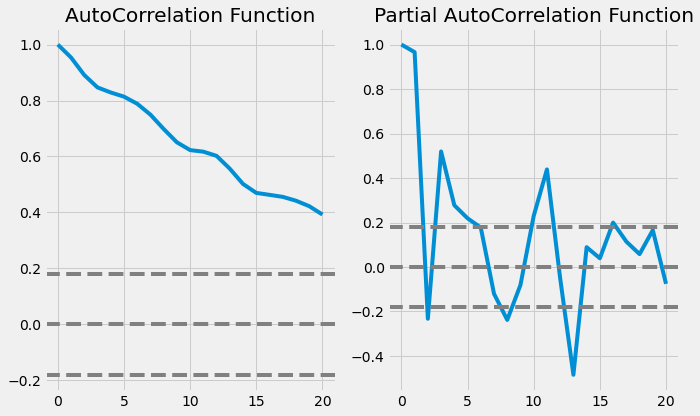

In [0]:
Plot_ACF_PACF(egg_train)

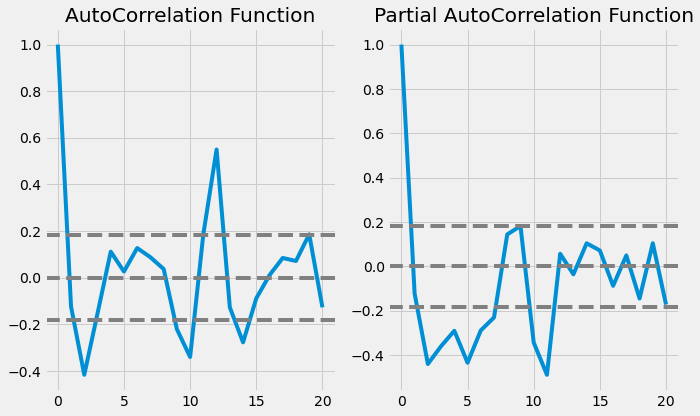

In [0]:
Plot_ACF_PACF(egg_diff2)

**Uji Coba Model Awal**

In [0]:
train_chicken = chicken_train
test_chicken = chicken_test

In [0]:
chicken_ARIMA = StepForwardARIMA([2, 2, 0], np.log(train_chicken), np.log(test_chicken))

In [0]:
predictions_chicken_ARIMA_original_value = np.exp(chicken_ARIMA)
predictions_chicken_ARIMA_original_value

,Price
Date,
2016-11-15,37072.457795
2016-12-15,37015.432662
2017-01-15,39098.042424
2017-02-15,40839.723914
2017-03-15,35983.824925
2017-04-15,37523.218137
2017-05-15,37502.975750
2017-06-15,40129.698612
2017-08-15,41022.724767


In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

ComparePredictions(predictions_chicken_ARIMA_original_value, test_chicken)

mse_ARIMA_chicken = mean_squared_error(test_chicken, predictions_chicken_ARIMA_original_value)
mae_ARIMA_chicken = mean_absolute_error(test_chicken, predictions_chicken_ARIMA_original_value)
mape_ARIMA_chicken = MAPE(predictions_chicken_ARIMA_original_value, test_chicken)

print('MSE: ', mse_ARIMA_chicken)
print('MAE: ', mae_ARIMA_chicken)
print('MAPE: ', mape_ARIMA_chicken)

-------------------- Compare Predictions --------------------
predicted:  37072.45779491051 , expected:  37547.0 , error:  474.5422050894922
predicted:  37015.43266155426 , expected:  38538.0 , error:  1522.5673384457405
predicted:  39098.04242438636 , expected:  39906.0 , error:  807.9575756136401
predicted:  40839.72391436663 , expected:  37480.0 , error:  3359.72391436663
predicted:  35983.824924775116 , expected:  37285.0 , error:  1301.1750752248845
predicted:  37523.21813715959 , expected:  37777.0 , error:  253.78186284041294
predicted:  37502.97574950691 , expected:  39133.0 , error:  1630.0242504930866
predicted:  40129.69861236318 , expected:  40123.0 , error:  6.6986123631795635
predicted:  41022.72476689632 , expected:  39868.0 , error:  1154.7247668963173
predicted:  40053.96979410302 , expected:  39031.0 , error:  1022.9697941030172
predicted:  38679.65873672531 , expected:  37856.0 , error:  823.6587367253087
predicted:  36943.25859792946 , expected:  38132.0 , error:  1

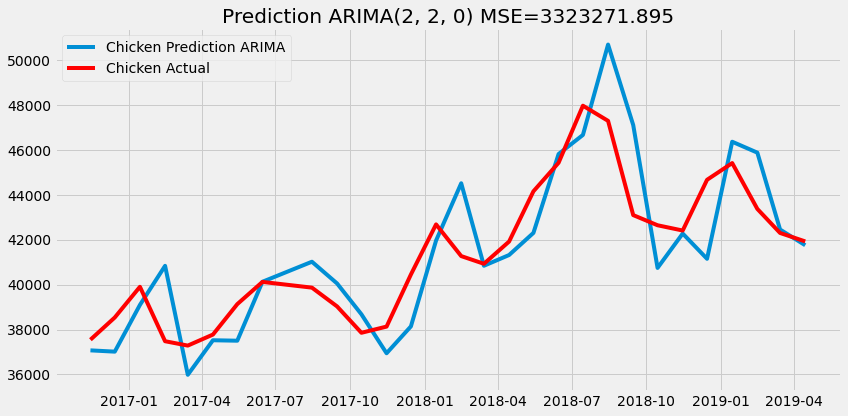

In [0]:
plt.figure(figsize=[12,6])
plt.title('Prediction ARIMA(2, 2, 0) MSE=%.3f' % mse_ARIMA_chicken)
plt.plot(predictions_chicken_ARIMA_original_value)
plt.plot(test_chicken, color='red')
plt.legend(['Chicken Prediction ARIMA', 'Chicken Actual'])
plt.tight_layout()

In [0]:
train_egg = egg_train
test_egg = egg_test

In [0]:
egg_SARIMA = StepForwardSARIMA([(2,0,0), (2,2,2,12), 't'], np.log(train_egg), np.log(test_egg))

In [0]:
predictions_egg_SARIMA_original_value = np.exp(egg_SARIMA)
predictions_egg_SARIMA_original_value

,Price
Date,
2016-11-15,19841.577533
2016-12-15,60309.565936
2017-01-15,22367.385950
2017-02-15,20437.277368
2017-03-15,17836.164611
2017-04-15,18766.619309
2017-05-15,19790.022659
2017-06-15,21745.057916
2017-08-15,19003.193935


In [0]:
ComparePredictions(predictions_egg_SARIMA_original_value, test_egg)

mse_SARIMA_egg = mean_squared_error(test_egg, predictions_egg_SARIMA_original_value)
mae_SARIMA_egg = mean_absolute_error(test_egg, predictions_egg_SARIMA_original_value)
mape_SARIMA_egg = MAPE(predictions_egg_SARIMA_original_value, test_egg)

print('MSE: ', mse_SARIMA_egg)
print('MAE: ', mae_SARIMA_egg)
print('MAPE: ', mape_SARIMA_egg)

-------------------- Compare Predictions --------------------
predicted:  19841.57753291087 , expected:  18909.0 , error:  932.5775329108692
predicted:  60309.56593609162 , expected:  20654.0 , error:  39655.56593609162
predicted:  22367.38595022557 , expected:  20590.0 , error:  1777.385950225569
predicted:  20437.277368180305 , expected:  19703.0 , error:  734.2773681803046
predicted:  17836.164611444365 , expected:  19181.0 , error:  1344.8353885556353
predicted:  18766.619308813206 , expected:  19008.0 , error:  241.38069118679414
predicted:  19790.022659285773 , expected:  20515.0 , error:  724.9773407142275
predicted:  21745.05791638104 , expected:  20439.0 , error:  1306.0579163810398
predicted:  19003.19393468062 , expected:  21375.0 , error:  2371.806065319379
predicted:  20775.063628433032 , expected:  20811.0 , error:  35.936371566967864
predicted:  20632.299010908417 , expected:  20395.0 , error:  237.29901090841668
predicted:  20733.59434332685 , expected:  20772.0 , error

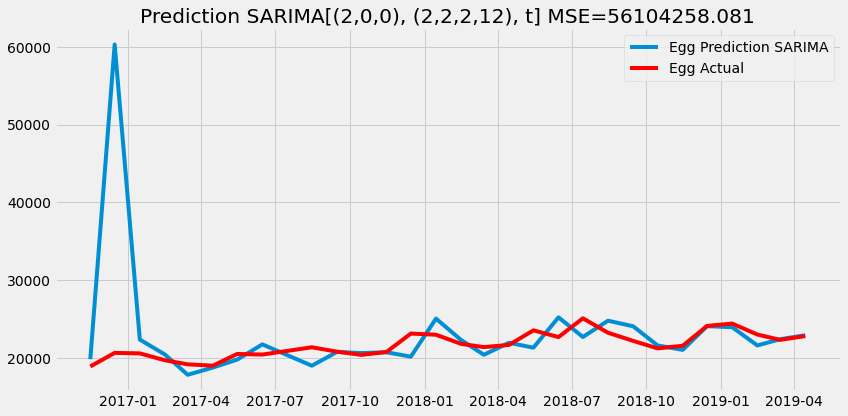

In [0]:
plt.figure(figsize=[12,6])
plt.title('Prediction SARIMA[(2,0,0), (2,2,2,12), t] MSE=%.3f' % mse_SARIMA_egg)
plt.plot(predictions_egg_SARIMA_original_value)
plt.plot(test_egg, color='red')
plt.legend(['Egg Prediction SARIMA', 'Egg Actual'])
plt.tight_layout()

**Ljung-Box Test**

In [0]:
chicken_ARIMA_decomposed = seasonal_decompose(predictions_chicken_ARIMA_original_value, freq=12)
chicken_ARIMA_residual = chicken_ARIMA_decomposed.resid
import statsmodels.api as sm
sm.stats.acorr_ljungbox(predictions_chicken_ARIMA_original_value, lags=12, boxpierce=False)

(array([15.2693397 , 20.25063549, 22.10630115, 25.28393298, 32.06861557,
        38.61095133, 40.6867416 , 40.74199224, 41.60227689, 42.03333853,
        42.05640399, 42.1909543 ]),
 array([9.32173685e-05, 4.00525689e-05, 6.19918387e-05, 4.41103692e-05,
        5.75824357e-06, 8.53074236e-07, 9.29776650e-07, 2.32939754e-06,
        3.88489076e-06, 7.39694316e-06, 1.58370366e-05, 3.09288799e-05]))

In [0]:
egg_SARIMA_decomposed = seasonal_decompose(predictions_egg_SARIMA_original_value, freq=12)
egg_SARIMA_residual = egg_SARIMA_decomposed.resid
import statsmodels.api as sm
sm.stats.acorr_ljungbox(predictions_egg_SARIMA_original_value, lags=12, boxpierce=False)

(array([0.0497721 , 0.06312821, 0.30242422, 0.40487256, 0.45769732,
        0.45879939, 0.62656953, 0.67275227, 0.79174718, 0.90775711,
        1.00533513, 1.2213166 ]),
 array([0.82346032, 0.96892884, 0.95957191, 0.98207603, 0.99359048,
        0.99830433, 0.99883855, 0.99959179, 0.99978607, 0.9998898 ,
        0.99994823, 0.9999572 ]))

**ARIMA(3, 1, 2)**

In [0]:
chicken_ARIMA = StepForwardARIMA([3, 1, 2], np.log(train_chicken), np.log(test_chicken))

In [0]:
predictions_chicken_ARIMA_original_value = np.exp(chicken_ARIMA)
predictions_chicken_ARIMA_original_value

,Price
Date,
2016-11-15,38908.583470
2016-12-15,39189.030548
2017-01-15,39453.229323
2017-02-15,39346.449053
2017-03-15,35915.597567
2017-04-15,36907.028418
2017-05-15,39061.007029
2017-06-15,40979.770585
2017-08-15,40704.314599


In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

ComparePredictions(predictions_chicken_ARIMA_original_value, test_chicken)

mse_ARIMA_chicken = mean_squared_error(test_chicken, predictions_chicken_ARIMA_original_value)
mae_ARIMA_chicken = mean_absolute_error(test_chicken, predictions_chicken_ARIMA_original_value)
mape_ARIMA_chicken = MAPE(predictions_chicken_ARIMA_original_value, test_chicken)

print('MSE: ', mse_ARIMA_chicken)
print('MAE: ', mae_ARIMA_chicken)
print('MAPE: ', mape_ARIMA_chicken)

-------------------- Compare Predictions --------------------
predicted:  38908.583470228106 , expected:  37547.0 , error:  1361.5834702281063
predicted:  39189.03054799447 , expected:  38538.0 , error:  651.0305479944727
predicted:  39453.229323245636 , expected:  39906.0 , error:  452.7706767543641
predicted:  39346.449052781136 , expected:  37480.0 , error:  1866.4490527811358
predicted:  35915.59756685755 , expected:  37285.0 , error:  1369.4024331424516
predicted:  36907.02841847797 , expected:  37777.0 , error:  869.9715815220334
predicted:  39061.007029229055 , expected:  39133.0 , error:  71.99297077094525
predicted:  40979.77058464766 , expected:  40123.0 , error:  856.7705846476601
predicted:  40704.314599221885 , expected:  39868.0 , error:  836.3145992218851
predicted:  38809.97237716433 , expected:  39031.0 , error:  221.027622835667
predicted:  37763.77896962132 , expected:  37856.0 , error:  92.22103037867782
predicted:  37788.15797203445 , expected:  38132.0 , error:  3

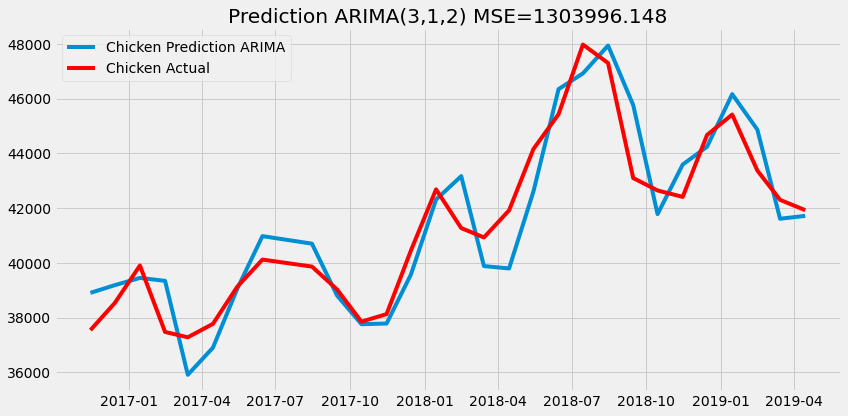

In [0]:
plt.figure(figsize=[12,6])
plt.title('Prediction ARIMA(3,1,2) MSE=%.3f' % mse_ARIMA_chicken)
plt.plot(predictions_chicken_ARIMA_original_value)
plt.plot(test_chicken, color='red')
plt.legend(['Chicken Prediction ARIMA', 'Chicken Actual'])
plt.tight_layout()

SARIMA[(2, 1, 1), (2, 0, 2, 0), n]

In [0]:
egg_SARIMA = StepForwardSARIMA([(2,1,1), (2,0,2,0), 'n'], np.log(train_egg), np.log(test_egg))

In [0]:
predictions_egg_SARIMA_original_value = np.exp(egg_SARIMA)
predictions_egg_SARIMA_original_value

,Price
Date,
2016-11-15,19751.919093
2016-12-15,19718.618319
2017-01-15,21411.612526
2017-02-15,20219.767046
2017-03-15,19009.149222
2017-04-15,19232.104688
2017-05-15,19350.491961
2017-06-15,21440.962296
2017-08-15,20447.737024


In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

ComparePredictions(predictions_egg_SARIMA_original_value, test_egg)

mse_SARIMA_egg = mean_squared_error(test_egg, predictions_egg_SARIMA_original_value)
mae_SARIMA_egg = mean_absolute_error(test_egg, predictions_egg_SARIMA_original_value)
mape_SARIMA_egg = MAPE(predictions_egg_SARIMA_original_value, test_egg)

print('MSE: ', mse_SARIMA_egg)
print('MAE: ', mae_SARIMA_egg)
print('MAPE: ', mape_SARIMA_egg)

-------------------- Compare Predictions --------------------
predicted:  19751.919093128356 , expected:  18909.0 , error:  842.9190931283556
predicted:  19718.618319113393 , expected:  20654.0 , error:  935.3816808866068
predicted:  21411.612526274417 , expected:  20590.0 , error:  821.6125262744172
predicted:  20219.767045803506 , expected:  19703.0 , error:  516.7670458035063
predicted:  19009.149222350523 , expected:  19181.0 , error:  171.8507776494771
predicted:  19232.104687584 , expected:  19008.0 , error:  224.1046875840002
predicted:  19350.491961150972 , expected:  20515.0 , error:  1164.5080388490278
predicted:  21440.962295935842 , expected:  20439.0 , error:  1001.9622959358421
predicted:  20447.7370239427 , expected:  21375.0 , error:  927.2629760573
predicted:  21298.777450662565 , expected:  20811.0 , error:  487.77745066256466
predicted:  19672.392925332337 , expected:  20395.0 , error:  722.6070746676633
predicted:  20204.84906689971 , expected:  20772.0 , error:  56

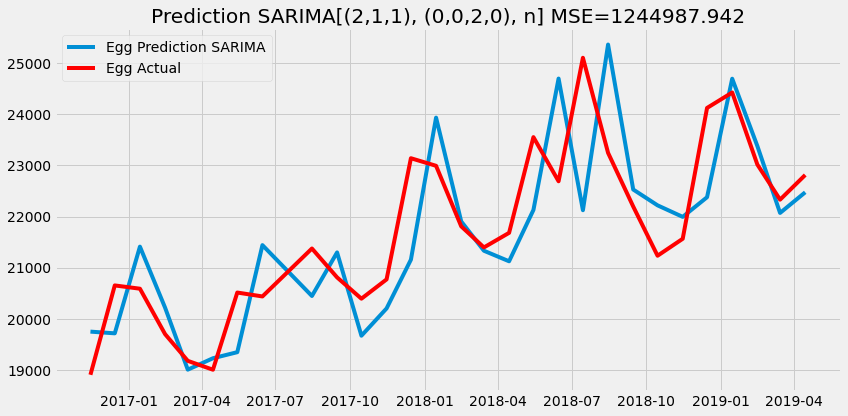

In [0]:
plt.figure(figsize=[12,6])
plt.title('Prediction SARIMA[(2,1,1), (0,0,2,0), n] MSE=%.3f' % mse_SARIMA_egg)
plt.plot(predictions_egg_SARIMA_original_value)
plt.plot(test_egg, color='red')
plt.legend(['Egg Prediction SARIMA', 'Egg Actual'])
plt.tight_layout()